# Exploratory Data Analysis
In this notebook, we will look at what descriptive information the images of chest x-rays can tell us.

## Import
---
### Packages

In [40]:
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import os
import gc

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing import image

In [41]:
# remove unnecessary variables
def clean_up(vars_):
    for var in vars_:
        del var 
    print(gc.collect())

### Images dataset

In [42]:
train_dir = 'DATA/train'
test_dir = 'DATA/test'
val_dir = 'DATA/validation'

## Example Data
---
Take a look at a few samples from normal and pneumonia sets.

In [43]:
# pull a few images from training
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/NORMAL') if fn.endswith('.jpeg')]
pneumo_imgs = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if fn.endswith('.jpeg')]

select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)   

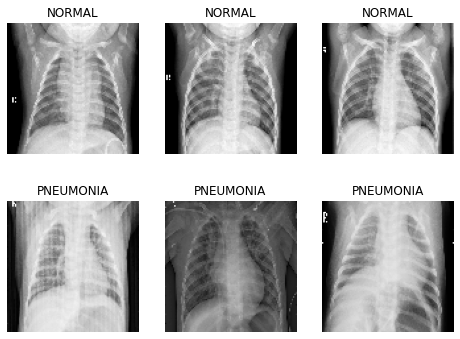

In [44]:
fig = plt.figure(figsize = (8,6))

for i in range(6):
    if i < 3:
        fp = f'{train_dir}/NORMAL/{select_norm[i]}'
        label = 'NORMAL'
    else:
        fp = f'{train_dir}/PNEUMONIA/{select_pneu[i-3]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 3, i+1)
    fn = image.load_img(fp, target_size = (100,100),
                        color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

From simply looking at couple of images it's hard to always tell pneumonia apart from normal lungs. But some of the pneumonia images do show less contrast or fuzzyniess around the lungs.

## Basic File Information
---
Information we can extract from files
### Distribution of Classes
Check how much data we have for each class.

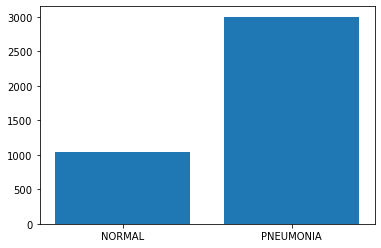

In [45]:
plt.bar(['NORMAL', 'PNEUMONIA'], [len(normal_imgs), len(pneumo_imgs)], )
plt.show()

A bit of class imbalance. This will bias towards pneumonia, which is a case we want, so we should re-evaluate our evaluation metrics.

## Image Information
---
Information we can extract from images

### Image as Numpy Array
For the rest of calculation, I will create a $n \times m$ matrix representing our dataset, where $n$ is the number of observation and $m$ is the value of each pixels (scaled and resized to $64\times64 = 4096$)

In [46]:
def img2np(pwd, fn_list, size = (64, 64)):
    for fn in fn_list:
        fp = pwd + fn
        current_image = image.load_img(fp, 
                                       target_size = size, 
                                       color_mode = 'grayscale')
        img_ts = image.img_to_array(current_image)
        img_ts = [img_ts.ravel()]
        try:
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            full_mat = img_ts
    return full_mat

In [47]:
normal_images = img2np(f'{train_dir}/NORMAL/', normal_imgs)
pnemonia_images = img2np(f'{train_dir}/PNEUMONIA/', pneumo_imgs)

### Mean Image
Display the mean image for normal vs. pneumonia classes  
For each pixel, I'll average across all images.

In [48]:
def find_mean_img(image_vecs, title, size = (64, 64)):
    mean_img = np.mean(image_vecs, axis = 0)
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'MEAN {title}')
    plt.axis('off')
    plt.show()
    return mean_img

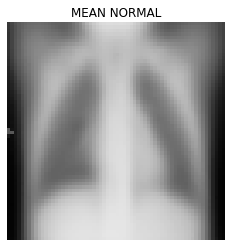

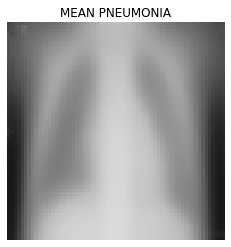

In [49]:
norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pnemonia_images, 'PNEUMONIA')

The average images clearly show the cloud on pneumonia X-rays making it difficult to identify a heart.

### Contrast between class
Show the difference between two class

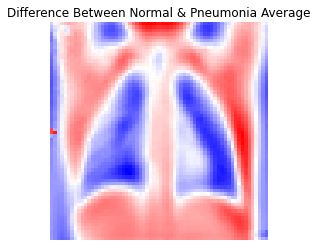

In [24]:
contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.show()

### Variability
Now I want to see which areas have the least/most amount of variability across the images in each class.

In [58]:
def find_std_img(image_vecs, title, size = (64, 64)):
    std_img = np.var(image_vecs, axis = 0)
    std_img = std_img.reshape(size)
    std_img = np.expand_dims(std_img, axis = 0)
    plt.imshow(std_img[0], cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

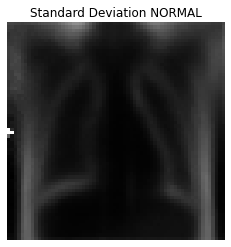

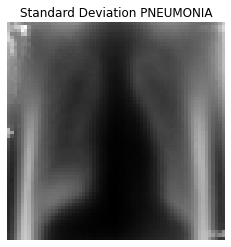

In [59]:
norm_std = find_std_img(normal_images, 'NORMAL')
pneu_std = find_std_img(pnemonia_images, 'PNEUMONIA')

### Eigenimages
Show a basis image after a dimensionality reduction  
https://en.wikipedia.org/wiki/Eigenface  
This is essentially just getting the principal components.

In [60]:
from sklearn.decomposition import PCA

In [61]:
def eigenimages(image_vecs, title, n_comp, size = (64, 64)):
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(image_vecs)
    plt.imshow(pca.mean_.reshape(size), cmap='Greys_r')
    plt.axis('off')
    plt.title(f'Eigenimage of {title}')
    plt.show()
    print('Number of PC: ', pca.n_components_)
    return pca

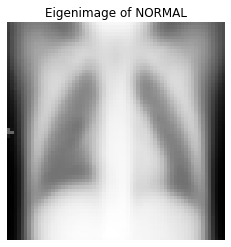

Number of PC:  28


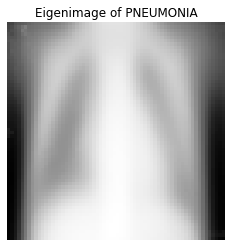

Number of PC:  14


In [62]:
norm_pca = eigenimages(normal_images, 'NORMAL', 0.7)
pneu_pca = eigenimages(pnemonia_images, 'PNEUMONIA', 0.7)

Now plotting each principal components.

In [63]:
from math import ceil
def plot_pcs(pca, size = (64, 64)):
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

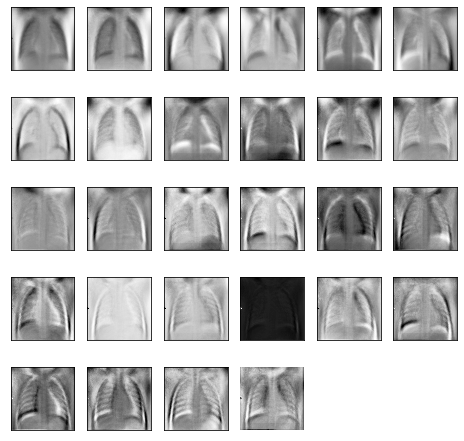

In [64]:
plot_pcs(norm_pca)

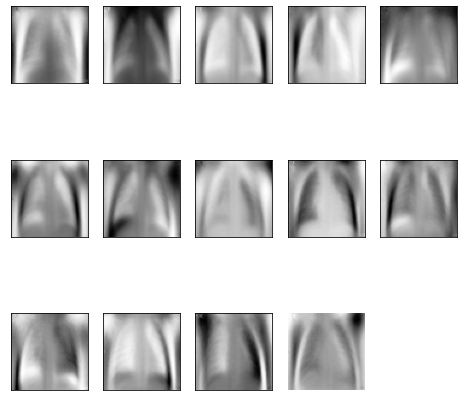

In [65]:
plot_pcs(pneu_pca)

### Clean Up

In [23]:
# remove image variable being stored to free up the memory
clean_up([normal_images, pnemonia_images])

71887
